In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import glob
import json
import seaborn as sns
from datetime import datetime
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
import re
from matplotlib import colormaps  
from aind_analysis_arch_result_access.han_pipeline import get_mle_model_fitting
from scipy.stats import linregress
from typing import Sequence



In [2]:
#Load kinematics data
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import (
    load_keypoints_from_csv,
    find_behavior_videos_folder,
    integrate_keypoints_with_video_time,
)

#keypoints
LP_csv_path = '/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_716325_2024-05-31_10-31-14/bottom_camera.csv'

keypoint_dfs = load_keypoints_from_csv(LP_csv_path)

session_name = os.path.basename(os.path.dirname(LP_csv_path))
behavior_videos_folder = find_behavior_videos_folder(f'/root/capsule/data/{session_name}')

#get video timebase for keypoint dataframe
keypoint_dfs_trimmed, video_csv_trimmed = integrate_keypoints_with_video_time(
    os.path.join(behavior_videos_folder, 'bottom_camera.csv'), 
    keypoint_dfs
)

keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Video QC: Frame numbers are sequential with no gaps.
Video QC: Timing differences are within expected range.
keypoint_df trimmed from 2689719 to 2689718


In [3]:
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import (
    mask_keypoint_data, kinematics_filter, segment_movements_trimnans
)

#tongue kinematics processing and movement segmentation
tongue_masked = mask_keypoint_data(keypoint_dfs_trimmed,'tongue_tip_center',confidence_threshold=0.90)
tongue_filtered = kinematics_filter(tongue_masked,cutoff_freq=50,filter_order=4,filter_kind='cubic')
tongue_segmented = segment_movements_trimnans(tongue_filtered, max_dropped_frames=10)

#tongue_segmented is a frame-level tidy datafram with tongue kinematics and movements segmented by 'movement_id'


In [4]:
#connect to nwb dfs
from aind_dynamic_foraging_behavior_video_analysis.kinematics.kinematics_nwb_utils import get_nwb_file
import aind_dynamic_foraging_data_utils.nwb_utils as nwb_utils
from aind_dynamic_foraging_basic_analysis.licks import annotation

nwb = get_nwb_file(session_name)
nwb.df_events = nwb_utils.create_events_df(nwb)
nwb.df_trials = nwb_utils.create_df_trials(nwb)
nwb.df_licks = annotation.annotate_licks(nwb)

Loading NWB from /root/capsule/data/foraging_nwb_bonsai/716325_2024-05-31_10-31-14.nwb


/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue


In [5]:
#annotate trial info, lick info, and make movement-level dataframe

from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import (
    annotate_trials_in_kinematics, annotate_licks_in_kinematics, assign_movements_to_licks,
    aggregate_tongue_movements, add_lick_metadata_to_movements
)

tongue_segmented = annotate_trials_in_kinematics(tongue_segmented, nwb.df_trials)
tongue_marked = annotate_licks_in_kinematics(tongue_segmented, nwb.df_licks, tolerance=0.01)
nwb.df_licks = assign_movements_to_licks(tongue_marked, nwb.df_licks)

tongue_movements = aggregate_tongue_movements(tongue_marked,keypoint_dfs_trimmed)

tongue_movements = add_lick_metadata_to_movements(
    tongue_movements,
    nwb.df_licks,
    fields=['cue_response', 'rewarded', 'event']
)

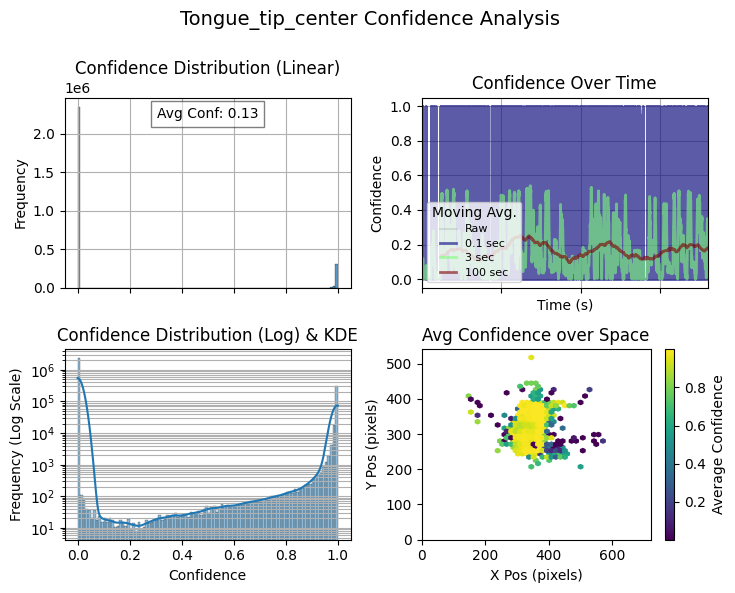

In [6]:
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import plot_keypoint_confidence_analysis, plot_basic_kinematics_movement_segment

plot_keypoint_confidence_analysis(keypoint_dfs_trimmed,'tongue_tip_center')

No data found for movement_id 0


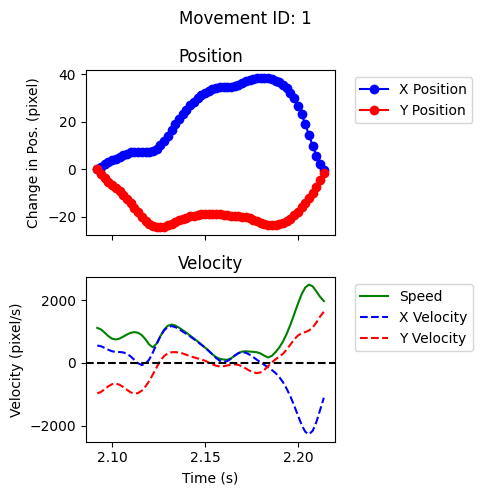

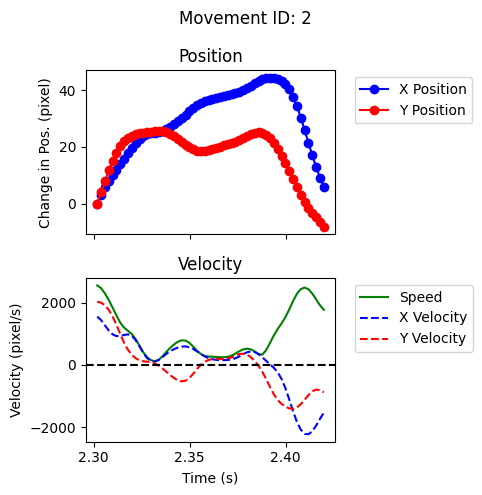

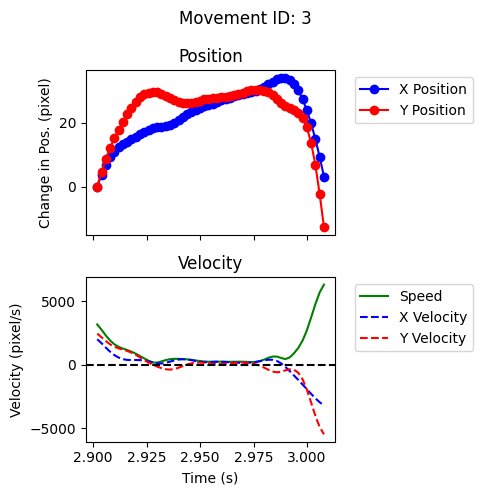

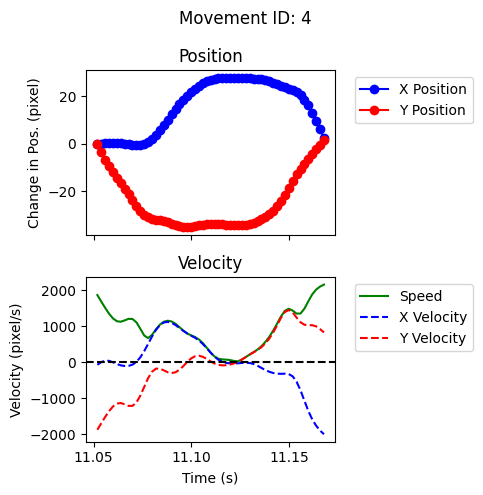

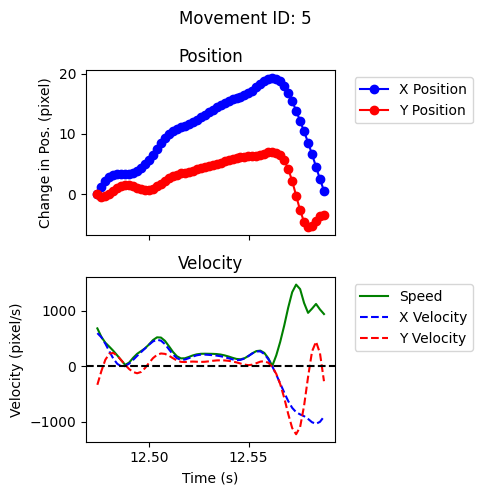

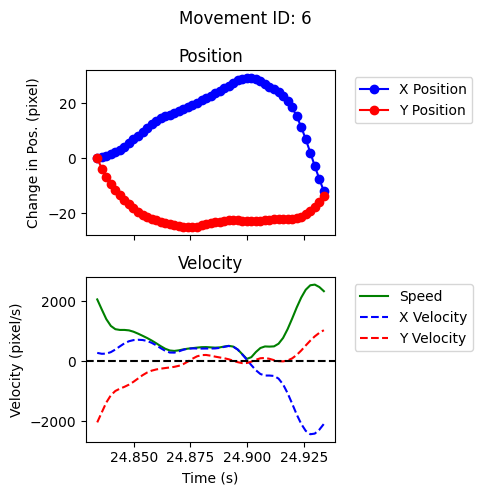

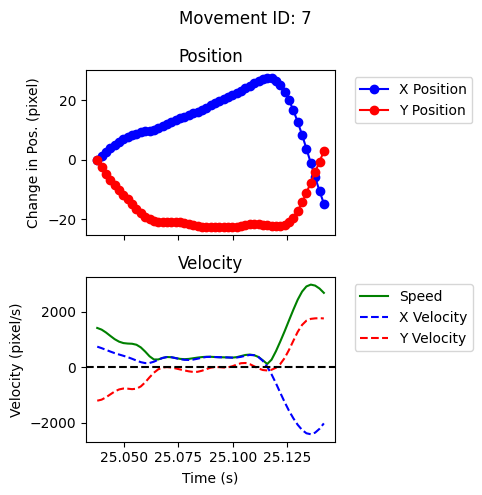

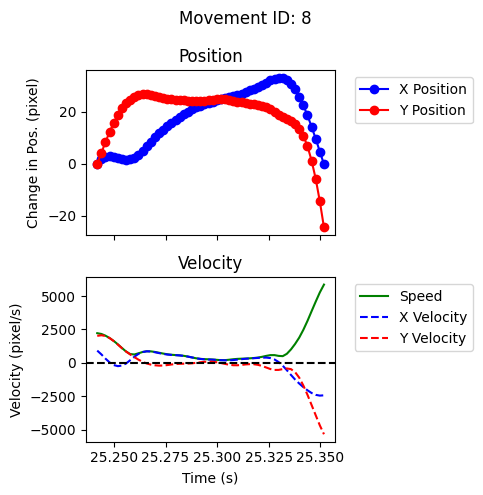

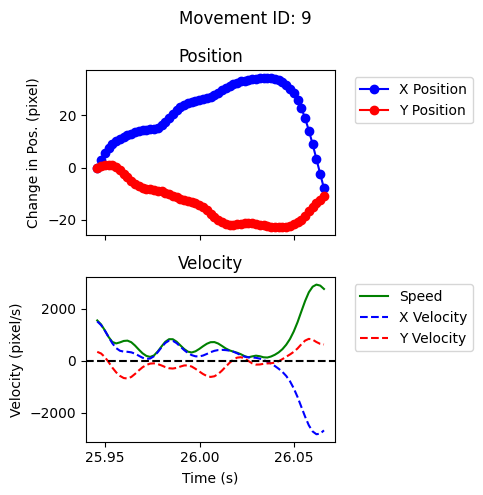

In [7]:
plot_basic_kinematics_movement_segment(tongue_segmented,movement_ids=list(range(10)))